## Imports

In [1]:
import MDAnalysis as mda
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from MDAnalysis.lib.distances import distance_array
from MDAnalysis import units
from MDAnalysis.analysis import rdf

from openmm.unit import Quantity, Unit
from openmm.unit import kelvin, bar, litre, kilojoule_per_mole, mole, nanometer, angstrom, kilocalorie_per_mole
from openmm.unit import AVOGADRO_CONSTANT_NA, BOLTZMANN_CONSTANT_kB
R = BOLTZMANN_CONSTANT_kB * AVOGADRO_CONSTANT_NA # gas constant

import quantities
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from pymbar import timeseries
from MDAnalysis.analysis import density
from tqdm import tqdm
import os
import json


/tmp/ipykernel_774842/3626084654.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.

****** PyMBAR will use 64-bit JAX! *******
* JAX is currently set to 32-bit bitsize *
* which is its default.                  *
*            

## Set working directory

In [2]:
# ffs=input("Which force fields? (Options: JC, CHARMM27)")
# os.chdir("/home/bamo6610/Documents/GROMACS_files/MDAnalysis/SPW_ALL/%s"%ffs)

os.chdir("/home/bamo6610/Documents/GROMACS_files/MDAnalysis/SPW_ALL/OpenFF2.1")

## Loading data and creating atom group of ions

In [3]:
## 1 molal ##
u1m_o = mda.Universe('mdr4_1m.pdb', 'mdr4_1m.xtc')
u1m_o.transfer_to_memory()
ions1m_o= u1m_o.select_atoms('resname NA CL')

u1m_r1 = mda.Universe('mdr1_1m.pdb', 'mdr1_1m.xtc')
u1m_r1.transfer_to_memory()
ions1m_r1= u1m_r1.select_atoms('resname NA CL')

u1m_r2 = mda.Universe('mdr2_1m.pdb', 'mdr2_1m.xtc')
u1m_r2.transfer_to_memory()
ions1m_r2= u1m_r2.select_atoms('resname NA CL')

u1m_r3 = mda.Universe('mdr3_1m.pdb', 'mdr3_1m.xtc')
u1m_r3.transfer_to_memory()
ions1m_r3= u1m_r3.select_atoms('resname NA CL')

us_1m = [u1m_o,u1m_r1,u1m_r2,u1m_r3]
ions_1m = [ions1m_o,ions1m_r1,ions1m_r2,ions1m_r3]

# ## 2 molal ##
u2m_o = mda.Universe('mdr4_2m.pdb', 'mdr4_2m.xtc')
u2m_o.transfer_to_memory()
ions2m_o= u2m_o.select_atoms('resname NA CL')

u2m_r1 = mda.Universe('mdr1_2m.pdb', 'mdr1_2m.xtc')
u2m_r1.transfer_to_memory()
ions2m_r1= u2m_r1.select_atoms('resname NA CL')

u2m_r2 = mda.Universe('mdr2_2m.pdb', 'mdr2_2m.xtc')
u2m_r2.transfer_to_memory()
ions2m_r2= u2m_r2.select_atoms('resname NA CL')

u2m_r3 = mda.Universe('mdr3_2m.pdb', 'mdr3_2m.xtc')
u2m_r3.transfer_to_memory()
ions2m_r3= u2m_r3.select_atoms('resname NA CL')

us_2m = [u2m_o,u2m_r1,u2m_r2,u2m_r3]
ions_2m = [ions2m_o,ions2m_r1,ions2m_r2,ions2m_r3]

# ## 3 molal ##
u3m_o = mda.Universe('mdr4_3m.pdb', 'mdr4_3m.xtc')
u3m_o.transfer_to_memory()
ions3m_o= u3m_o.select_atoms('resname NA CL')

u3m_r1 = mda.Universe('mdr1_3m.pdb', 'mdr1_3m.xtc')
u3m_r1.transfer_to_memory()
ions3m_r1= u3m_r1.select_atoms('resname NA CL')

u3m_r2 = mda.Universe('mdr2_3m.pdb', 'mdr2_3m.xtc')
u3m_r2.transfer_to_memory()
ions3m_r2= u3m_r2.select_atoms('resname NA CL')

u3m_r3 = mda.Universe('mdr3_3m.pdb', 'mdr3_3m.xtc')
u3m_r3.transfer_to_memory()
ions3m_r3= u3m_r3.select_atoms('resname NA CL')

us_3m = [u3m_o,u3m_r1,u3m_r2,u3m_r3]
ions_3m = [ions3m_o,ions3m_r1,ions3m_r2,ions3m_r3]

## Utility functions

In [4]:
from typing import TypeAlias, TypeVar
Shape : TypeAlias = tuple
N = TypeVar('N')
M = TypeVar('M')

from openmm.unit import molar, kilogram, picoseconds
from dataclasses import dataclass

In [5]:
@dataclass
class Wall:
    '''For representing info about the location and orientation of a wall'''
    wall_pos : Quantity
    wall_normal : Quantity

@dataclass
class IonMolalInfo:
    molality : Quantity
    n_parts : int
    osm_coeff_exp : float
    molarity : Quantity = None

def osmotic_values(
        mean_force_wall : Quantity, 
        molarity : Quantity,
        cross_sectional_area : Quantity, 
        vant_hoff : int=2,
        T : Quantity=300*kelvin, 
        printvals : bool=False
    ) -> Quantity:
    '''Compute osmotic pressure and coefficient from mean force from wall'''
    osm_press=mean_force_wall/cross_sectional_area
    osm_bar = osm_press.in_units_of(bar / mole)
    osm_bar = osm_bar/AVOGADRO_CONSTANT_NA
    
    osm_press_ideal=vant_hoff*molarity*R*T
    osm_press_ideal=osm_press_ideal.in_units_of(bar)
    osm_coeff=osm_bar/osm_press_ideal
    
    if printvals:
        print(f"Osmotic Pressure Observed:", osm_bar)
        print(f"Osmotic Pressure Ideal:", osm_press_ideal)
        print(f"Osmotic Coefficient:", osm_coeff)

    return osm_bar, osm_coeff

def filter_coords_by_wall(
    coords_rel_wall : np.ndarray[Shape[N, M, 3], float], 
    wall_normal : np.ndarray[Shape[3], float],
    dist_unit : Unit=angstrom,
) -> np.ndarray[Shape[N, M, 3], float]:
    '''Zeros out all coordinates which are not in the normal direction relative to a wall'''
    in_right_direction = np.dot(coords_rel_wall, wall_normal) > 0.0
    return np.where(in_right_direction[..., np.newaxis], coords_rel_wall, 0.0) * dist_unit # need to broadcast direction bools, since dot product reduces dimension along xyz

def calculate_force_matrix_all_ions_rel_wall(
    coords : np.ndarray[Shape[N, M, 3], float], 
    wall_pos : np.ndarray[Shape[3], float],
    wall_normal : np.ndarray[Shape[3], float],
    K : Quantity,
    dist_unit : Unit=angstrom,
) -> np.ndarray[Shape[M], float]:
    '''Calculates net harmonic force experience by particle on one side of a wall
    coords should be a 3D array with axes of time, ion index, and spatial coordinate, respectively
    wall_pos is a vector describing the position of the wall in space
    wall_normal gives the normal direction relative to the wall (to determine whether particles behnd or ahead of the wall are kept)'''
    coords_rel_wall = coords - wall_pos
    coords_behind_wall = filter_coords_by_wall(coords_rel_wall, wall_normal=wall_normal, dist_unit=dist_unit)
    z_coords_rel_wall = coords_behind_wall[..., 2]

    # NOTE: cannot use np.abs, as this will discard unit info
    return K * abs(z_coords_rel_wall) # sum along time dimension to leave array with 1 force per particle


## Old functions

In [6]:
def calculate_net_force(z_values : np.ndarray[float], zwall : float, k : float) -> float:
    return k * abs(z_values - zwall).sum()

def get_universe_area_and_volume(u : mda.Universe) -> tuple[Quantity, Quantity]:
    '''Returns the XY-plane area and box volume of an MDAnalysis universe'''
    box_sizes = u.dimensions[:3] * angstrom
    box_x, box_y, box_z = box_sizes

    A_box = box_x * box_y
    V_box = A_box * box_z

    return A_box, V_box

def SPW_analysis(
        times : np.ndarray[1, Quantity],
        ion_coords : np.ndarray[Shape[N, M, 3], Quantity],
        molality_info : IonMolalInfo,
        k : Quantity,
        A_box : Quantity,
        walls : list[Wall],
        repnum : int,
        nskip : int=100,
    ) -> None:
    '''DOCS'''

    SPACER = f'\n{"-"*50}\n'

    print(SPACER)
    print(f"CONCENTRATION: {molality_info.molality}")

    #Specifying replicate number
    if repnum == 0:
        print("Data for original run")
    else:
        print("Data for replicate #",repnum)

    ## calculation of mean force matrix
    force_matrices = [
        calculate_force_matrix_all_ions_rel_wall(
            ion_coords,
            wall_pos=wall.wall_pos,
            wall_normal=wall.wall_normal,
            K=k,
            dist_unit=angstrom
        )    
        for wall in walls
     ]
    # print(
    #     [
    #         osmotic_values(fm.mean(axis=0).sum(), molarity=molality_info.molarity, cross_sectional_area=A_box)
    #         for fm in force_matrices
    #     ]
    # )
    if force_matrices:
        NULL_FORCE = 0.0 * force_matrices[0].unit # needed to get sum to start with the right units (can't just add to 0)

    force_matrix = sum(force_matrices, start=NULL_FORCE) / len(force_matrices) # NOTE: need to average over all walls, and numpy can't get the job done on its own
    forces_time_avg = force_matrix.mean(axis=0)
    forces_over_all_ions = force_matrix.sum(axis=1)

    ## calculation of autocorrelation function and plot of uncorrelated samples
    # statistical values of t0 (time after equil), g (statistical efficiency/correlation time of equil data), Neff (# of eff samples)
    t0, g, Neff_max = timeseries.detect_equilibration(forces_over_all_ions._value, nskip=nskip) # compute indices of uncorrelated timeseries
    forces_over_all_ions_equil = forces_over_all_ions[t0:]
    uncorr_sample_idxs = timeseries.subsample_correlated_data(forces_over_all_ions_equil, g=g)
    uncorr_sample_idxs = np.array(uncorr_sample_idxs)
    
    sample_forces = forces_over_all_ions_equil[uncorr_sample_idxs]
    sample_times  = times[uncorr_sample_idxs]

    # mean of full time series
    force_mean = sample_forces.mean()
    force_std  = sample_forces.std() / np.sqrt(Neff_max - 1) # TODO: make sure propagation of errors is being done correctly (since now the addition is being done up-front)

    ## calculation of osmotic values from statistical mean and std error
    print(f"FINAL STATISTICAL RESULTS:")
    osm_press_mean, osm_coeff_mean = osmotic_values(force_mean, molarity=molality_info.molarity, cross_sectional_area=A_box) 
    osm_press_std , osm_coeff_std  = osmotic_values(force_std , molarity=molality_info.molarity, cross_sectional_area=A_box)

    print(f"Osmotic Pressure = {osm_press_mean}+/-{osm_press_std**2}")
    print(f"\nOsmotic Coefficient = {osm_coeff_mean}+/-{osm_coeff_std**2}")
    print(SPACER)
    
    ################################################################################################
    # results = {
    #     'os_press_mean' : osm_press_mean,
    #     'os_press_std'  : osm_press_std ,
    #     'os_press_var'  : osm_press_std**2,
    #     'os_coeff_mean' : osm_coeff_mean,
    #     'os_coeff_std'  : osm_coeff_std ,
    #     'os_coeff_var'  : osm_coeff_std**2,
    # }
    results = dict()
    
    results['os_press_mean'] = osm_press_mean
    results['os_press_var'] = osm_press_std**2
    results['os_coeff_mean'] = osm_coeff_mean
    results['os_coeff_var'] = osm_coeff_std**2
    
    return results


## Computing releavnt physical quantities and running Osmotic calculations / stats

In [7]:
# define wall positions and ion conc parameters
walls = [
    Wall(
        wall_pos   =np.array([0.0, 0.0, 48.0]) * angstrom,
        wall_normal=np.array([0.0, 0.0, -1.0]) * angstrom,
    ),
    Wall(
        wall_pos   =np.array([0.0, 0.0, 96.0]) * angstrom,
        wall_normal=np.array([0.0, 0.0, 1.0]) * angstrom,
    ),
]

molal_infos = {
    1 : IonMolalInfo(
        molality=1.0*(mole / kilogram),
        n_parts=65,
        osm_coeff_exp=0.940,
        # molarity=0.98*molar
    ),
    2 : IonMolalInfo(
        molality=2.0*(mole / kilogram),
        n_parts=128,
        osm_coeff_exp=0.984,
        # molarity=1.92*molar
    ),
    3 : IonMolalInfo(
        molality=3.0*(mole / kilogram),
        n_parts=188,
        osm_coeff_exp=1.045,
        # molarity=2.82*molar
    ),
}

In [8]:
# pick your specific parameters here
# u = u1m_o
# atom_group = ions1m_o

# m_info = molal_infos[1]
# k = 4184 * kilojoule_per_mole / nanometer**2
def run_analysis(u,atom_group,concentration,repnum):
    m_info = molal_infos[concentration]
    k = 4184 * kilojoule_per_mole / nanometer**2
    # pre-processing parameters
    times = np.array([u.trajectory.time for _ in u.trajectory]) * picoseconds
    all_coords = u.trajectory.coordinate_array * angstrom
    ion_coords = all_coords[:, atom_group.indices, :]

    A_box, V_box = get_universe_area_and_volume(u)
    wall_sep = abs(walls[1].wall_pos - walls[0].wall_pos)[2] # !NEED TO EXTRACT Z-COMPONENT OF COORDINATE DIFFERENCE!
    V_mem = A_box * wall_sep
    m_info.molarity = m_info.n_parts / (V_mem * AVOGADRO_CONSTANT_NA)

    k = k.in_units_of(kilojoule_per_mole / angstrom**2)

    # run analysis
    results = SPW_analysis(times, ion_coords, m_info, k, A_box, walls, repnum)
    return results



In [9]:
results1m=list()
for i,(ui,ionsi) in enumerate(zip(us_1m,ions_1m)):
    results1m.append(run_analysis(ui,ionsi,1,i))


--------------------------------------------------

CONCENTRATION: 1.0 mol/kg
Data for original run
FINAL STATISTICAL RESULTS:
Osmotic Pressure = 51.05890111603839 bar+/-3.7537518576077837 bar**2

Osmotic Coefficient = 1.05078883609435+/-0.0015898404145762127

--------------------------------------------------


--------------------------------------------------

CONCENTRATION: 1.0 mol/kg
Data for replicate # 1
FINAL STATISTICAL RESULTS:
Osmotic Pressure = 48.70479271336957 bar+/-2.7151604670073377 bar**2

Osmotic Coefficient = 1.002174489864275+/-0.0011495789169558592

--------------------------------------------------


--------------------------------------------------

CONCENTRATION: 1.0 mol/kg
Data for replicate # 2
FINAL STATISTICAL RESULTS:
Osmotic Pressure = 49.644341816979704 bar+/-3.6225631441296753 bar**2

Osmotic Coefficient = 1.0206782098731242+/-0.0015312783292616935

--------------------------------------------------


--------------------------------------------------


In [10]:
results2m=list()
for i,(ui,ionsi) in enumerate(zip(us_2m,ions_2m)):
    results2m.append(run_analysis(ui,ionsi,2,i))


--------------------------------------------------

CONCENTRATION: 2.0 mol/kg
Data for original run
FINAL STATISTICAL RESULTS:
Osmotic Pressure = 109.08813132165405 bar+/-12.935172449083137 bar**2

Osmotic Coefficient = 1.1386293170446375+/-0.0014092302002444415

--------------------------------------------------


--------------------------------------------------

CONCENTRATION: 2.0 mol/kg
Data for replicate # 1
FINAL STATISTICAL RESULTS:
Osmotic Pressure = 97.3408324877659 bar+/-9.844166243030058 bar**2

Osmotic Coefficient = 1.017877271140842+/-0.001076414800483712

--------------------------------------------------


--------------------------------------------------

CONCENTRATION: 2.0 mol/kg
Data for replicate # 2
FINAL STATISTICAL RESULTS:
Osmotic Pressure = 104.65011563885867 bar+/-5.132785365923244 bar**2

Osmotic Coefficient = 1.093148396030163+/-0.000560056604016234

--------------------------------------------------


--------------------------------------------------

CO

In [11]:
results3m=list()
for i,(ui,ionsi) in enumerate(zip(us_3m,ions_3m)):
    results3m.append(run_analysis(ui,ionsi,3,i))


--------------------------------------------------

CONCENTRATION: 3.0 mol/kg
Data for original run
FINAL STATISTICAL RESULTS:
Osmotic Pressure = 168.42704479123535 bar+/-14.661853474681735 bar**2

Osmotic Coefficient = 1.1984006746613207+/-0.0007422826464722634

--------------------------------------------------


--------------------------------------------------

CONCENTRATION: 3.0 mol/kg
Data for replicate # 1
FINAL STATISTICAL RESULTS:
Osmotic Pressure = 163.24994506700756 bar+/-15.792208361267726 bar**2

Osmotic Coefficient = 1.1640323020345789+/-0.0008029099542437559

--------------------------------------------------


--------------------------------------------------

CONCENTRATION: 3.0 mol/kg
Data for replicate # 2
FINAL STATISTICAL RESULTS:
Osmotic Pressure = 161.53387964392007 bar+/-12.244096233442376 bar**2

Osmotic Coefficient = 1.1493065496609889+/-0.0006198280839177822

--------------------------------------------------


----------------------------------------------

In [12]:
print(type(results1m))

<class 'list'>


In [13]:
# for i in results3m:
#     print(results3m[i])

### Stdev between replicates

In [14]:
def results_replicates(results,concentration):
    op_vals = list()
    oc_vals = list()
    op_errs = list()
    oc_errs = list()

    for r in results:
        v = r['os_press_mean']
        op_vals.append(v.value_in_unit(v.unit))
        v = r['os_press_var']
        op_errs.append(v.value_in_unit(v.unit))
        oc_vals.append(r['os_coeff_mean'])
        oc_errs.append(r['os_coeff_var'])
    oc_vals = np.array(oc_vals)
    op_vals = np.array(op_vals)
    op_errs = np.array(op_errs)
    oc_errs = np.array(oc_errs)

    print("----- Results standard deviation over replicates for %s molal -----"%concentration)
    stdop = op_vals.std(ddof=1)
    # print(f'std of osmotic presssure: {stdop:.3f}')
    stdoc = oc_vals.std(ddof=1)
    # print(f'std of osmotic coeff: {stdoc:.3f}')

    print("mean of osmotic pressure replicates: ",end="")
    mean_op=op_vals.mean()
    op_err=stdop/np.sqrt(len(op_vals))
    print(f'osmotic pressure {mean_op:.3f} +/- {op_err:.3f}')
    
    print("mean of osmotic coefficient replicates: ",end="")
    mean_oc=oc_vals.mean()
    oc_err=stdoc/np.sqrt(len(oc_vals))
    print(f'osmotic coeff {mean_oc:.3f} +/- {oc_err:.3f}')

    final_results = dict()

    final_results['mean_osmotic_pressure'] = mean_op
    final_results['uncertainity_osmotic_pressure'] = op_err
    
    final_results['mean_osmotic_coefficient'] = mean_oc
    final_results['uncertainity_osmotic_coefficient'] = oc_err

    return final_results


In [15]:
reps1m=results_replicates(results1m,1)
reps2m=results_replicates(results2m,2)
reps3m=results_replicates(results3m,3)

----- Results standard deviation over replicates for 1 molal -----
mean of osmotic pressure replicates: osmotic pressure 50.232 +/- 0.647
mean of osmotic coefficient replicates: osmotic coeff 1.033 +/- 0.013
----- Results standard deviation over replicates for 2 molal -----
mean of osmotic pressure replicates: osmotic pressure 102.239 +/- 2.825
mean of osmotic coefficient replicates: osmotic coeff 1.068 +/- 0.029
----- Results standard deviation over replicates for 3 molal -----
mean of osmotic pressure replicates: osmotic pressure 163.050 +/- 1.995
mean of osmotic coefficient replicates: osmotic coeff 1.162 +/- 0.014


## Write results to json file

In [16]:
# with open("final_results.txt","w") as file:
#     file.write("-- 1 molal replicate analysis --"+"\n")
#     file.write(f"Mean osmotic pressure: {reps1m['mean_osmotic_pressure']:.3f} +/- {reps1m['uncertainity_osmotic_pressure']:.3f} \n")
#     file.write(f"Mean osmotic coefficient: {reps1m['mean_osmotic_coefficient']:.3f} +/- {reps1m['uncertainity_osmotic_coefficient']:.3f} \n")

In [17]:
def format_dict(dictionary):
    newdict = {}
    for x in dictionary:
        if isinstance(dictionary[x],float):
            newdict[x] = round(dictionary[x],3)
        else:
            newdict[x] = dictionary[x]
    return newdict

In [18]:
json_1m=json.dumps(format_dict(reps1m),indent=4)
json_2m=json.dumps(format_dict(reps2m),indent=4)
json_3m=json.dumps(format_dict(reps3m),indent=4)

with open("final_results_1m.json","w") as outfile:
    outfile.write(json_1m)

with open("final_results_2m.json","w") as outfile:
    outfile.write(json_2m)

with open("final_results_3m.json","w") as outfile:
    outfile.write(json_3m)

## Density profiles using MDanalysis

In [19]:
def density_profile(universe, atom_group, bin_width=0.5, dim='z', method='atom', frameby=1):
    '''Calculate the partial density across the box'''

    if isinstance(atom_group, str): # if provided selection language, make AtomGroup
        ag = universe.select_atoms(atom_group)
    else: # else assume input is AtomGroup
        ag = atom_group

    print(f'\nCalculating the partial density profile of {atom_group} in the {dim} dimension...')

    dims = {'x': 0, 'y': 1, 'z': 2}
    d = dims[dim]
    box = universe.dimensions[d]

    n_bins = int(box / bin_width)
    bins = np.linspace(0, box, num=n_bins)

    counts = np.zeros(n_bins-1)
        
    if len(universe.trajectory) == 0:
        for b in tqdm(range(n_bins-1)):
            lb = bins[b]
            ub = bins[b+1]
            bin_atoms = universe.select_atoms(f'prop {dim} > {lb} and prop {dim} < {ub} and group ag', ag=ag)
            if method in ['atom', 'atoms', 'all']:
                counts[b] += len(bin_atoms)
            elif method in ['molecule', 'mol', 'residue', 'res']: 
                counts[b] += bin_atoms.n_residues
            elif method in ['mass', 'mass density']:
                box_dims = [box[i] for i in range(3) if i != d]
                dV = box_dims[0] * box_dims[1] * (ub-lb) * (10**-8)**3
                mass = bin_atoms.masses.sum() / 6.022 / 10**23
                counts[b] += mass / dV
    else:
        for ts in tqdm(universe.trajectory[::frameby]):
            for b in range(n_bins-1):
                lb = bins[b]
                ub = bins[b+1]
                bin_atoms = universe.select_atoms(f'prop {dim} > {lb} and prop {dim} < {ub} and group ag', ag=ag)

                if method in ['atom', 'atoms', 'all', 'number']:
                    counts[b] += len(bin_atoms)                 
                elif method in ['molecule', 'mol', 'residue', 'res']: 
                    counts[b] += bin_atoms.n_residues
                elif method in ['mass', 'mass density']:
                    box_dims = [box[i] for i in range(3) if i != d]
                    dV = box_dims[0] * box_dims[1] * (ub-lb) * (10**-8)**3
                    mass = bin_atoms.masses.sum() / 6.022 / 10**23
                    counts[b] += mass / dV

        counts = counts / len(universe.trajectory[::frameby])

    return bins/10, counts

In [20]:
nbins1,ncounts1=density_profile(u1m_o,ions1m_o)
nbins2,ncounts2=density_profile(u2m_o,ions2m_o)
nbins3,ncounts3=density_profile(u3m_o,ions3m_o)


Calculating the partial density profile of <AtomGroup [<Atom 11101: Na00 of type Na of resname NA, resid 1 and segid I and altLoc >, <Atom 11102: Na01 of type Na of resname NA, resid 1 and segid J and altLoc >, <Atom 11103: Na02 of type Na of resname NA, resid 1 and segid K and altLoc >, ..., <Atom 11228: Cl62 of type Cl of resname CL, resid 1 and segid F and altLoc >, <Atom 11229: Cl63 of type Cl of resname CL, resid 1 and segid G and altLoc >, <Atom 11230: Cl64 of type Cl of resname CL, resid 1 and segid H and altLoc >]> in the z dimension...


100%|██████████| 1000/1000 [10:34<00:00,  1.58it/s]



Calculating the partial density profile of <AtomGroup [<Atom 11101: Na00 of type Na of resname NA, resid 1 and segid I and altLoc >, <Atom 11102: Na01 of type Na of resname NA, resid 1 and segid J and altLoc >, <Atom 11103: Na02 of type Na of resname NA, resid 1 and segid K and altLoc >, ..., <Atom 11354: Cl12 of type Cl of resname CL, resid 1 and segid B and altLoc >, <Atom 11355: Cl12 of type Cl of resname CL, resid 1 and segid C and altLoc >, <Atom 11356: Cl12 of type Cl of resname CL, resid 1 and segid D and altLoc >]> in the z dimension...


100%|██████████| 1000/1000 [10:41<00:00,  1.56it/s]



Calculating the partial density profile of <AtomGroup [<Atom 11101: Na00 of type Na of resname NA, resid 1 and segid I and altLoc >, <Atom 11102: Na01 of type Na of resname NA, resid 1 and segid J and altLoc >, <Atom 11103: Na02 of type Na of resname NA, resid 1 and segid K and altLoc >, ..., <Atom 11474: Cl18 of type Cl of resname CL, resid 1 and segid R and altLoc >, <Atom 11475: Cl18 of type Cl of resname CL, resid 1 and segid S and altLoc >, <Atom 11476: Cl18 of type Cl of resname CL, resid 1 and segid T and altLoc >]> in the z dimension...


100%|██████████| 1000/1000 [18:19<00:00,  1.10s/it]


### Density plots

NameError: name 'bins' is not defined

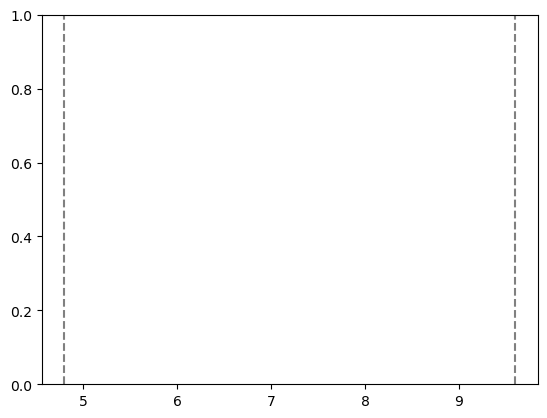

In [21]:
# nb=144.4/72
# volbin=48*48*nb*angstrom**3
# counts=(ncounts/AVOGADRO_CONSTANT_NA)/volbin.in_units_of(litre)/2
# counts1=(ncounts1/AVOGADRO_CONSTANT_NA)/volbin.in_units_of(litre)/2
# counts2=(ncounts2/AVOGADRO_CONSTANT_NA)/volbin.in_units_of(litre)/2
# counts3=(ncounts3/AVOGADRO_CONSTANT_NA)/volbin.in_units_of(litre)/2

# bins=nbins/10
# bins1=nbins1/10
# bins2=nbins2/10
# bins3=nbins3/10

# print(counts)

plt.axvline(x = 4.8, color = 'gray', label = 'walls', linestyle = 'dashed')
plt.axvline(x = 9.6, color = 'gray', linestyle = 'dashed')
plt.axhline(y = 1, color = 'lightgray', linestyle = 'dashed')
plt.plot(bins[1:],counts, c='orange', label='original')
plt.plot(bins1[1:],counts1, c='g', label='rep1')
plt.plot(bins2[1:],counts2, c='c', label='rep2')
plt.plot(bins3[1:],counts3, c='m', label='rep3')

plt.xlabel("Z coordinate (nm)")
plt.ylabel("Concentration (mol/L)")
plt.xticks(np.arange(0, 14.4, 1))
plt.title("Concentration profile of replicates - CHARMM27")
plt.legend()
plt.show()